# PyTorchで実装するGNN

- データセット：cora
- タスク：ノード分類
- GNN：GraphSAGE
- Dense表現で実装します（Dense表現では，大規模なグラフの場合にメモリが溢れてしまうので，Sparse表現を使用する必要があります）

#  データセットのダウンロード

データセットにはcoraを使用します．
論文の引用ネットワークで，タスクは7種類のノード分類です．

特徴量は1433種類のワードが含まれているかどうかの0/1 (Bag-of-Words)

参考：<a href=https://disassemble-channel.com/graph-cora-datasets/>【グラフ構造】論文の引用データセットCoraを利用する</a>

In [15]:
# データセットの読み込み
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root="./Cora", name="Cora")

data = dataset[0] # データの中身を受け取る

Processing...
Done!


## データの中身を見てみる

In [16]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [17]:
print('特徴量の形状: ', data.x.size()) # ノード数 × 特徴量の次元数
print('正解ラベルの形状: ', data.y.size()) # ノード数
print('エッジのインデックスの形状: ', data.edge_index.size()) # 2 × エッジ数

特徴量の形状:  torch.Size([2708, 1433])
正解ラベルの形状:  torch.Size([2708])
エッジのインデックスの形状:  torch.Size([2, 10556])


### 特徴量を見てみる

In [18]:
print('data.x[0]:',data.x[0]) # 0が多い
print('data.x[0]のうち，0でない要素',data.x[0].nonzero().tolist())

data.x[0]: tensor([0., 0., 0.,  ..., 0., 0., 0.])
data.x[0]のうち，0でない要素 [[19], [81], [146], [315], [774], [877], [1194], [1247], [1274]]


### 正解ラベルを見てみる

In [19]:
print('data.y[0]:',data.y[0].item())

data.y[0]: 3


### グラフを見てみる
networkxを使用して可視化を行います

In [20]:
print('data.edge_index\n',data.edge_index)

data.edge_index
 tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])


In [21]:
import networkx as nx
import matplotlib.pyplot as plt

# 対象ノードから3hop以内のノードを探索し，可視化する関数
def plot_3hop(node_idx):

    # メモ：わかりやすさ重視の非効率なコードです．
    # メモ：setを使用して重複を除去しています．


    edge_index_for_node_idx = []


    ### 1hop以内のノードを取得 ###

    one_hop_nodes_set = set()

    # 全てのエッジについて
    for i,j in data.edge_index.t().tolist():
        
        # ソースノードがnode_idxの場合
        if i == node_idx:
            one_hop_nodes_set.add(j)
            edge_index_for_node_idx.append([i,j])
        
        # ターゲットノードがnode_idxの場合
        if j == node_idx:
            one_hop_nodes_set.add(i)
            edge_index_for_node_idx.append([i,j])

    one_hop_nodes_list = list(one_hop_nodes_set) # リストに変換


    ### 2hop以内のノードを取得 ###
    two_hop_nodes_set = set()

    # 全てのエッジについて
    for i,j in data.edge_index.t().tolist():
        
        # ソースノードが1hopのノードの場合
        if i in one_hop_nodes_list:
            two_hop_nodes_set.add(j)
            edge_index_for_node_idx.append([i,j])
        
        # ターゲットノードが1hopのノードの場合
        if j in one_hop_nodes_list:
            two_hop_nodes_set.add(i)
            edge_index_for_node_idx.append([i,j])

    two_hop_nodes_list = list( two_hop_nodes_set - {node_idx} ) # 自分自身を除く．リストに変換．


    ### 3hop以内のノードを取得 ###
    three_hop_nodes_set = set()

    # 全てのエッジについて
    for i,j in data.edge_index.t().tolist():
        
        # ソースノードが2hopのノードの場合
        if i in two_hop_nodes_list:
            three_hop_nodes_set.add(j)
            edge_index_for_node_idx.append([i,j])
        
        # ターゲットノードが2hopのノードの場合
        if j in two_hop_nodes_list:
            three_hop_nodes_set.add(i)
            edge_index_for_node_idx.append([i,j])
            
    # three_hop_nodes_list = list( three_hop_nodes_set - {node_idx} ) # 自分自身を除く．リストに変換．
    

    ### 可視化 ###
    G = nx.Graph()

    # エッジの追加
    for i,j in edge_index_for_node_idx:
        G.add_edge(i,j)

    # 正解ラベルと色の対応
    color_dict = {0:'r', 1:'g', 2:'gray', 3:'y', 4:'lightblue', 5:'purple', 6:'orange'}

    # 正解ラベルによる色分け
    node_color = []
    for node in G.nodes():
        y = data.y[node].item()
        node_color.append(color_dict[y])

    plt.figure(figsize=(15,6))
    nx.draw(G, with_labels=True, node_color=node_color, node_size=1000)

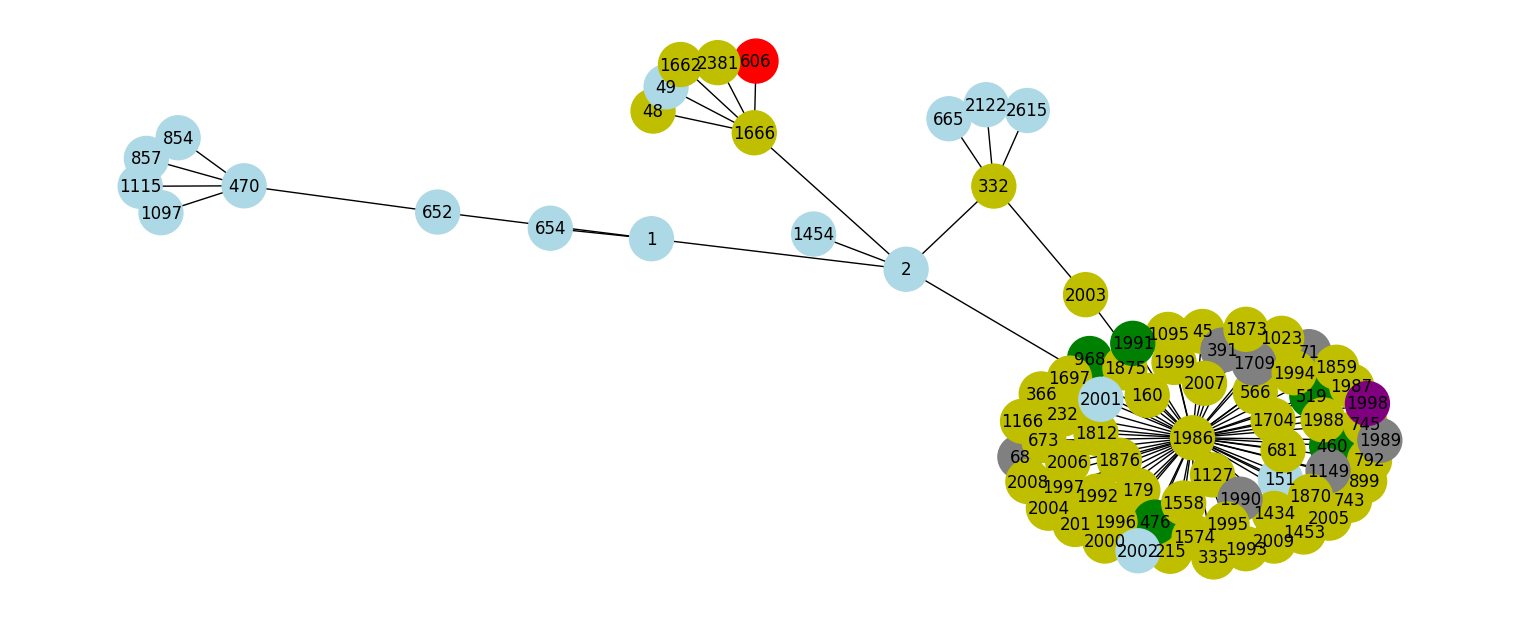

In [24]:
plot_3hop(1) # ノード0を中心に3hop以内を可視化

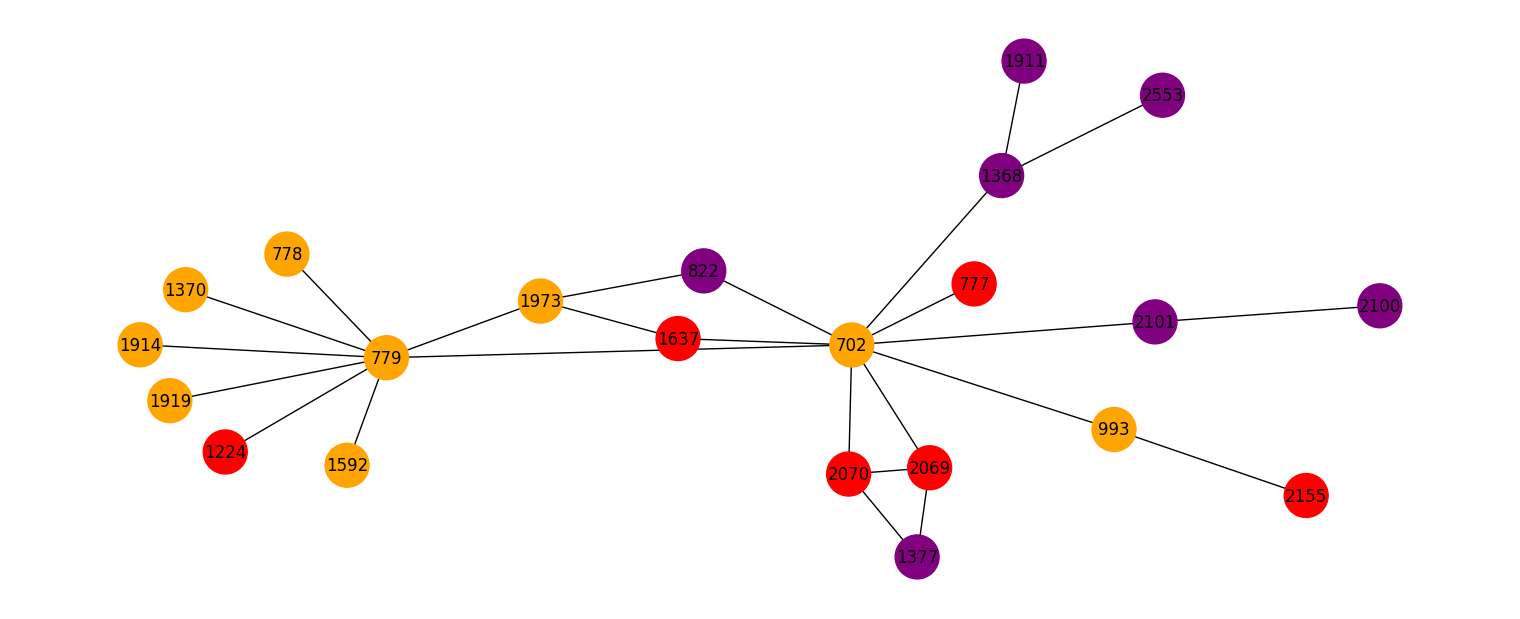

In [25]:
plot_3hop(777) # ノード777を中心に3hop以内を可視化

#### コメント：エッジがつながっているノードはラベルが同じであることが多いです，このことをホモフィリーと言います．

# GNNモデルの作成

## GraphSAGEについて簡単な解説


GraphSAGEとは<a href=https://papers.nips.cc/paper_files/paper/2017/file/5dd9db5e033da9c6fb5ba83c7a7ebea9-Paper.pdf>Inductive Representation Learning on Large Graphs</a>[1]
という論文で提案されているGNNモデルの1種です．

ちなみに，SAGEは **SA**mple and aggre**G**at**E** から来ています．（わかりにくい...）

[1] William L. Hamilton, Rex Ying, and Jure Leskovec. Inductive representation learning on large graphs. In Proceedings of the NeurIPS, 2017

GraphSAGEでは色々な集約方法(Aggregator)が提案されていますが，ここでは**Mean aggregator**を使用します．またここではサンプリングを行いません．

### GraphSAGEの更新式
$$
h_v^k \leftarrow \sigma(W \cdot \text{MEAN})(\{ h_v^{k-1} \} \cup \{ h_u^{k-1} \,|\, \forall u \in \mathcal{N}(v) \})
$$

- $(\{ h_v^{k-1} \} \cup \{ h_u^{k-1} \,|\, \forall u \in \mathcal{N}(v) \})$で自分自身と近傍の特徴量を集めています．
- $W \cdot \text{MEAN} ... $で集めてきた特徴量の平均を取り，そのあと重み行列を掛けています．
- $\sigma$は活性化関数です．ReLUがよく用いられます．

この計算式を以下で試してみます

In [26]:
### MEAN ###

import torch

torch.manual_seed(777) # 乱数のシードを固定

# 更新前の特徴量
h_v = torch.rand(3) # 3次元の特徴量とする
h_u = torch.rand(2,3) # 隣接ノードが2つあるとする

# 特徴量の平均を取る関数
def Calc_MEAN(h_v, h_u):
    h_u_sum = h_u.sum(dim=0) # まず，h_uの各行を足し合わせる
    h_u_num = h_u.size(0) # h_uの行数を取得
    return (h_v + h_u_sum) / (h_u_num + 1) # h_vと足し合わせた後，行数+1で割る

MEAN = Calc_MEAN(h_v, h_u)

print('特徴量を集める')
print('h_v   :',[round(i,2) for i in h_v.tolist()])
# print('h_u:',h_u.tolist())
for i in range(2):
    print('h_u['+str(i)+']:',[round(j,2) for j in h_u[i].tolist()])
print('\n')

print('集めた特徴量の平均を取る')
print('MEAN  :',[round(i,2) for i in MEAN.tolist()])
print('\n')


### 重み行列を掛ける ###
W = torch.randn(3,3) # ランダムな値で試す．

W_MEAN = W @ MEAN # 行列の積

print('平均した特徴量に重み行列を掛ける')
print('\tW\t    MEAN')
for i in range(3):
    
    for j in range(3):
        print(f'{W[i][j]:>5.2f}', end=' ')

    print(' ',f'{MEAN.tolist()[i]:.2f}')
print('\n')

print('W@MEAN:',[round(i,2) for i in W_MEAN.tolist()])
print('\n')


### 活性化関数に通す ###

def ReLU(x):
    return torch.max(x, torch.zeros_like(x)) # max(0,x)を返す

h_v_new = ReLU(W_MEAN) # h_v_newを計算

print('ReLUに通す')
print('h_v\'  :',[round(i,2) for i in h_v_new.tolist()])

特徴量を集める
h_v   : [0.08, 0.49, 0.4]
h_u[0]: [0.39, 0.88, 0.88]
h_u[1]: [0.72, 0.5, 0.82]


集めた特徴量の平均を取る
MEAN  : [0.4, 0.63, 0.7]


平均した特徴量に重み行列を掛ける
	W	    MEAN
 1.32  1.05  2.20   0.40
-0.41 -0.38 -0.26   0.63
 0.16 -1.99 -0.63   0.70


W@MEAN: [2.73, -0.58, -1.62]


ReLUに通す
h_v'  : [2.73, 0.0, 0.0]


## GraphSAGEレイヤーを定義

In [27]:
class GraphSAGE_Layer(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GraphSAGE_Layer, self).__init__()

        self.W = torch.nn.Parameter(torch.FloatTensor(input_dim, output_dim)) # 重み行列
        
        self.init_params() # 重み行列の初期化
    
    def init_params(self):
        torch.nn.init.xavier_normal_(self.W) # 重み行列をXavierで初期化

    def forward(self, h_v, h_u_sum, degree): # h_v: 自身の特徴量, h_u_sum: 隣接ノードの特徴量の和，degree: 次数
        
        MEAN = (h_v + h_u_sum) / (degree + 1)
        
        return MEAN @ self.W # 行列表記
    
    def reset_parameters(self):
        self.init_params()

## 2層のGraphSAGEクラスを作成

In [30]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        """
        input_dim: 入力次元数（特徴量の次元）
        hidden_dim: 隠れ層の次元数（任意）
        output_dim: 出力次元数（クラス数）
        """
        
        self.layer1 = GraphSAGE_Layer(input_dim, hidden_dim)
        self.layer2 = GraphSAGE_Layer(hidden_dim, output_dim)
    
    def reset_parameters(self):
        self.layer1.reset_parameters()
        self.layer2.reset_parameters()
    
    def forward(self, data, adj):
        h_v = data.x
        
        degree = adj.sum(dim=1, keepdim=True) # 各ノードの次数
        
        # 1層目
        h_u_sum = self.aggerate(h_v, adj) # 隣接ノードの特徴量を集める
        h_v = self.layer1(h_v, h_u_sum, degree) # 隣接ノードの特徴量を集める
        h_v = torch.nn.functional.relu(h_v)
        
        # 2層目
        h_u_sum = self.aggerate(h_v, adj)
        h_v = self.layer2(h_v, h_u_sum, degree)
        h_v = torch.nn.functional.softmax(h_v, dim=1) # 多クラス分類なので，活性化関数にソフトマックスを使用
        
        return h_v
        
    def aggerate(self, x, adj):
        
        return adj @ x # 隣接行列を掛けることで，隣接しているノードの特徴量の和が得られる．

# 学習

In [31]:
import torch_geometric


model = GraphSAGE(input_dim=dataset.num_features, hidden_dim=64, output_dim=dataset.num_classes)

adj = torch_geometric.utils.to_dense_adj(data.edge_index)[0] # 隣接行列

epoch = 50
lr = 0.001 # learning rate

optimizer = torch.optim.Adam(model.parameters(), lr=lr) # 最適化手法にAdamを使用

model.reset_parameters() # パラメータの初期化

acc_hist = {'train':[], 'val':[], 'test':[]} # 正解率の履歴を記録する


for i in range(epoch):
    
    # 勾配を初期化
    optimizer.zero_grad()
    
    # クラスラベルを予測
    pred = model(data, adj)
    
    # 損失を計算，多クラス分類なので，クロスエントロピーを使用
    pred_train = pred[data.train_mask]
    y_train = data.y[data.train_mask]

    # ロスの計算と逆伝播
    loss = torch.nn.functional.cross_entropy(pred_train, y_train)
    loss.backward()

    # パラメータを更新
    optimizer.step()
    
    print(f'epoch: {i+1:02}, loss: {loss.item():.03f}', end='\t')
    

    # 正解率を計算
    pred_cls = pred.argmax(dim=1) # クラスラベルを取得
    
    pred_cls_train = pred_cls[data.train_mask]
    y_cls_train = data.y[data.train_mask]
    acc_train = (pred_cls_train == y_cls_train).sum().item() / y_cls_train.size(0)
    acc_hist['train'].append(acc_train)
    
    pred_cls_val = pred_cls[data.val_mask]
    y_cls_val = data.y[data.val_mask]
    acc_val = (pred_cls_val == y_cls_val).sum().item() / y_cls_val.size(0) 
    acc_hist['val'].append(acc_val)
    
    pred_cls_test = pred_cls[data.test_mask]
    y_cls_test = data.y[data.test_mask]
    acc_test = (pred_cls_test == y_cls_test).sum().item() / y_cls_test.size(0)
    acc_hist['test'].append(acc_test)
    
    print(f'train accuracy: {acc_train:.03f}, val accuracy: {acc_val:.03f}, test accuracy: {acc_test:.03f}')


epoch: 01, loss: 1.946	train accuracy: 0.164, val accuracy: 0.152, test accuracy: 0.144
epoch: 02, loss: 1.942	train accuracy: 0.264, val accuracy: 0.224, test accuracy: 0.219
epoch: 03, loss: 1.938	train accuracy: 0.400, val accuracy: 0.300, test accuracy: 0.314
epoch: 04, loss: 1.933	train accuracy: 0.543, val accuracy: 0.414, test accuracy: 0.393
epoch: 05, loss: 1.929	train accuracy: 0.686, val accuracy: 0.476, test accuracy: 0.477
epoch: 06, loss: 1.924	train accuracy: 0.786, val accuracy: 0.546, test accuracy: 0.537
epoch: 07, loss: 1.919	train accuracy: 0.829, val accuracy: 0.592, test accuracy: 0.582
epoch: 08, loss: 1.913	train accuracy: 0.864, val accuracy: 0.620, test accuracy: 0.625
epoch: 09, loss: 1.907	train accuracy: 0.893, val accuracy: 0.658, test accuracy: 0.661
epoch: 10, loss: 1.901	train accuracy: 0.914, val accuracy: 0.676, test accuracy: 0.681
epoch: 11, loss: 1.895	train accuracy: 0.921, val accuracy: 0.694, test accuracy: 0.706
epoch: 12, loss: 1.888	train acc

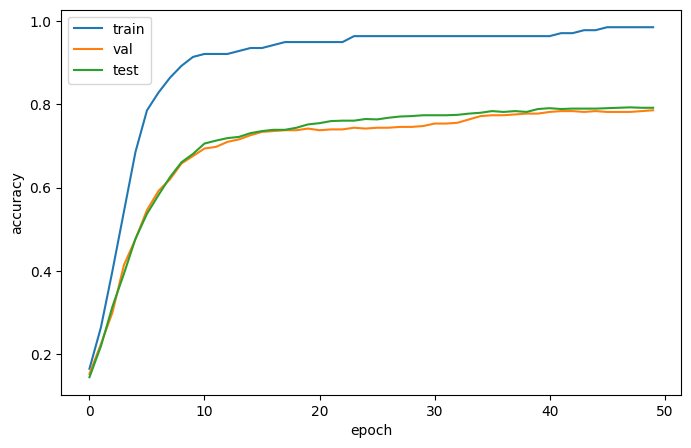

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(acc_hist['train'], label='train')
plt.plot(acc_hist['val'], label='val')
plt.plot(acc_hist['test'], label='test')

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()